# <center> **BERT-Based Sentiment Classification for Food Insecurity Tweets**</center>
<center>(BERT-based Sentiment Classification & Model Evaluation)</center>

### 📌 Notebook Overview
This notebook builds upon the initial data cleaning and exploratory analysis work by training a powerful BERT model to classify tweets related to food security into multiple sentiment categories. We will carefully prepare the data, handle imbalanced classes, fine-tune a pretrained BERT, and evaluate the model’s performance using robust metrics.

**🎯 Goal ?** Fine-tune a BERT model on our cleaned and translated tweet dataset to accurately classify each tweet 

🔗 [Check out here: Data Cleaning & NLP Pipeline for Social Media Opinions on Food Security in Malaysia](https://www.kaggle.com/code/dhaouadiibtihel98/clean-data-sentiment-analysis-lda-topic-modeling/notebook#%F0%9F%94%8D-Step-3:-Load-and-Explore-the-Dataset)

### Key Steps & Workflow:
1. **🧹 Data Preparation & Encoding**
   * Encoding classes into numerical labels
   * Tokenization using BertTokenizer from HuggingFace
   * Handling class imbalance using Weighted loss functions
   * Split the dataset into training, validation, and test sets
2. **🏗️ Building and Fine-tuning the BERT Classifier**
   * Load a pre-trained BERT model (bert-base-uncased)
   * Add a custom classification head for 4 sentiment classes
   * Use AdamW optimizer and learning rate scheduler for stable training
   * Fine-tune using our labeled tweets
3. **🔁 Training and Evaluation Loops**
   * Custom train_epoch() and eval_model() functions with metric tracking
   * Evaluation using accuracy, precision, recall, and F1-score (weighted to account for imbalance)
   * Integrated learning rate scheduling & optimizer tuning
4. **📈 Performance Visualization**
   * Plot detailed training and validation curves
   * Validating model performance to avoid overfitting
   * Visualize performance using Confusion Matrix and ROC Curve.

## **📚 Import Necessary Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc as roc_auc_score_func

from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn import CrossEntropyLoss

from collections import Counter

2025-06-10 17:56:23.238779: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749578183.420496      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749578183.470927      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Check device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device:", device)

Using device: cuda


## **🧹 Data Preparation & Encoding**

### 🔍 Load Dataset

In [3]:
path = '/kaggle/input/sentiment-analysis-for-food-insecurity/food_security_processed_data.csv'
df = pd.read_csv(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34103 entries, 0 to 34102
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Datetime         34103 non-null  object 
 1   Username         34103 non-null  object 
 2   Text             34103 non-null  object 
 3   Location         34103 non-null  object 
 4   translated_Text  34103 non-null  object 
 5   Cleaned_Text     33948 non-null  object 
 6   sentiment_score  34103 non-null  float64
 7   sentiment_label  34103 non-null  object 
 8   risk_level       34103 non-null  object 
 9   assigned_topic   34103 non-null  object 
 10  risk_score       34103 non-null  int64  
dtypes: float64(1), int64(1), object(9)
memory usage: 2.9+ MB


### 🔢 Encode Classes into Numerical Labels

Before training, we need to convert the categorical **sentiment_label** into **numerical** form using **label encoding**.

In [4]:
# Encode the sentiment labels into numerical format
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['sentiment_label'])
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Sentiment classes:", class_mapping)

Sentiment classes: {'negative': 0, 'positive': 1, 'very negative': 2, 'very positive': 3}


In [5]:
print(df['label_encoded'].value_counts())

label_encoded
0    20382
1     9392
3     2733
2     1596
Name: count, dtype: int64


### 🧼 Tokenization and Padding with BERT Tokenizer

In [6]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

token_lengths = []
for text in tqdm(df['Cleaned_Text'].fillna("")):
    tokens = tokenizer.encode(text, add_special_tokens=True)
    token_lengths.append(len(tokens))

print("Max length:", np.max(token_lengths))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 34103/34103 [00:09<00:00, 3775.28it/s]

Max length: 94


In [7]:
# Tokenize and encode the text
encoded_inputs = tokenizer(
    df['Cleaned_Text'].fillna("").tolist(),  # Convert Series to list and handle NaNs
    padding=True,
    truncation=True,
    return_tensors='pt',  # Return PyTorch tensors
    max_length=95
)
encoded_inputs['input_ids']

tensor([[ 101, 7501, 1054,  ...,    0,    0,    0],
        [ 101, 2028, 2851,  ...,    0,    0,    0],
        [ 101, 7501, 3612,  ...,    0,    0,    0],
        ...,
        [ 101, 7501, 2292,  ...,    0,    0,    0],
        [ 101, 3435, 2075,  ...,    0,    0,    0],
        [ 101, 9302, 3433,  ...,    0,    0,    0]])

In [8]:
# Define inputs and targets
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']
labels = torch.tensor(df['label_encoded'].values)

# Vérification des formes
print("input_ids shape:", input_ids.shape)
print("attention_masks shape:", attention_masks.shape)
print("labels shape:", labels.shape)

input_ids shape: torch.Size([34103, 94])
attention_masks shape: torch.Size([34103, 94])
labels shape: torch.Size([34103])


### ⚖️ Handling Class Imbalance 

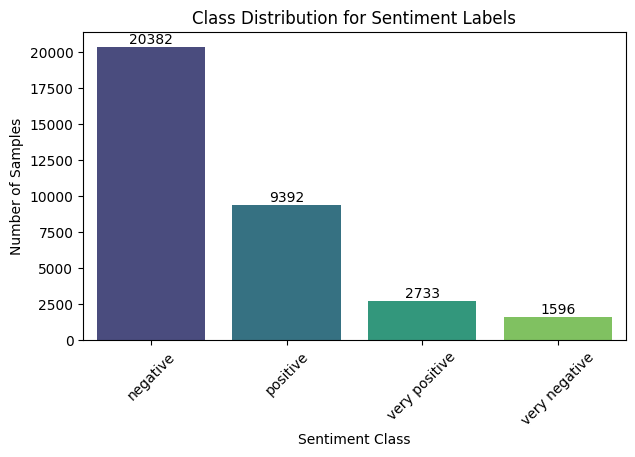

In [9]:
# Plot class distribution to check for imbalance
class_counts = df['sentiment_label'].value_counts()

plt.figure(figsize=(7,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Class Distribution for Sentiment Labels')
plt.ylabel('Number of Samples')
plt.xlabel('Sentiment Class')
plt.xticks(rotation=45)
for i, count in enumerate(class_counts.values):
    plt.text(i, count + max(class_counts.values)*0.01, str(count), ha='center')
plt.show()

📊 To address the issue of class imbalance in our sentiment labels, we compute **class weights** using `sklearn`’s `compute_class_weight` function. This ensures that underrepresented classes are not ignored during training, and the model is penalized more when it misclassifies minority classes. 

These computed weights will later be incorporated into our loss function (`CrossEntropyLoss`) to guide the model towards fairer predictions across all sentiment categories.


In [10]:
# Compute class weights for sentiment
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label_encoded']),
    y=df['label_encoded']
)
class_weights_dict = {i : weight for i, weight in enumerate(class_weights)}
print("Class weights (sentiment):", class_weights_dict)

Class weights (sentiment): {0: 0.4182980080463154, 1: 0.9077672487223168, 2: 5.341948621553884, 3: 3.1195572630808637}


### 🔀 Split Dataset into Train, Validation and Test Sets

We split the data into **80% training**, **17% validation**, and **3% test sets** with stratification to keep class distribution consistent.

In [11]:
# Define inputs and targets
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']
labels = df['label_encoded'].values

# Train-test split
X_train, X_temp, y_train, y_temp, mask_train, mask_temp = train_test_split(
    input_ids, labels, attention_masks, test_size=0.3, random_state=42, stratify=labels)

# Validation-test split
X_val, X_test, y_val, y_test, mask_val, mask_test = train_test_split(
    X_temp, y_temp, mask_temp, test_size=0.3333, random_state=42, stratify=y_temp)

print(f"Training set size: {len(y_train)}")
print(f"Validation set size: {len(y_val)}")
print(f"Test set size: {len(y_test)}")

Training set size: 23872
Validation set size: 6821
Test set size: 3410


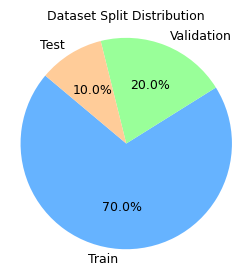

In [12]:
# Sizes of each dataset
sizes = [len(X_train), len(X_val), len(X_test)]
labels = ['Train', 'Validation', 'Test']
colors = ['#66b3ff','#99ff99','#ffcc99']

plt.figure(figsize=(3,3))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 9})
plt.title('Dataset Split Distribution', fontsize=9)
plt.axis('equal')
plt.show()

## **🏗️ Building and Fine-tuning the BERT Classifier**


### **Define a Custom Dataset Class**

In [13]:
# Define Dataset class
class FoodSecurityDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

### **Create DataLoaders**

In [14]:
# Create datasets
train_dataset = FoodSecurityDataset(X_train, mask_train, y_train)
val_dataset = FoodSecurityDataset(X_val, mask_val, y_val)
test_dataset = FoodSecurityDataset(X_test, mask_test, y_test)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### **Load Pre-trained BERT Model for Classification**

In [15]:
# Load BERT model for sequence classification (4 classes)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [16]:
# Print model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable parameters: {count_parameters(model):,}")

Trainable parameters: 109,485,316


In [17]:
# Prepare optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 4
total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Class weights tensor
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn = CrossEntropyLoss(weight=weights)

## **🔁 Training and Evaluation Loops**


### **Training & Evaluation Functions**

In [18]:
# Training function
def train_epoch(model, dataloader, loss_fn, optimizer, scheduler):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.detach().cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    return avg_loss, accuracy, precision, recall, f1

In [19]:
# Evaluation function
def eval_model(model, dataloader, loss_fn):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.detach().cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    return avg_loss, accuracy, precision, recall, f1, all_labels, all_preds


### **Train the Model**

In [20]:
# Training loop
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_precision': [], 'val_recall': [], 'val_f1': []}

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    train_loss, train_acc, train_prec, train_rec, train_f1 = train_epoch(model, train_loader, loss_fn, optimizer, scheduler)
    val_loss, val_acc, val_prec, val_rec, val_f1, _, _ = eval_model(model, val_loader, loss_fn)

    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, F1: {train_f1:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1: {val_f1:.4f}")

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_prec)
    history['val_recall'].append(val_rec)
    history['val_f1'].append(val_f1)


Epoch 1/4


Evaluating: 100%|██████████| 214/214 [00:18<00:00, 11.46it/s]


Train Loss: 0.4999, Accuracy: 0.7983, Precision: 0.7924, Recall: 0.7983, F1: 0.7923
Val   Loss: 0.3012, Accuracy: 0.8799, Precision: 0.8818, Recall: 0.8799, F1: 0.8744

Epoch 2/4


Evaluating: 100%|██████████| 214/214 [00:18<00:00, 11.47it/s]


Train Loss: 0.2308, Accuracy: 0.9146, Precision: 0.9138, Recall: 0.9146, F1: 0.9140
Val   Loss: 0.2379, Accuracy: 0.9101, Precision: 0.9111, Recall: 0.9101, F1: 0.9102

Epoch 3/4


Evaluating: 100%|██████████| 214/214 [00:18<00:00, 11.46it/s]


Train Loss: 0.1318, Accuracy: 0.9545, Precision: 0.9543, Recall: 0.9545, F1: 0.9544
Val   Loss: 0.2557, Accuracy: 0.9097, Precision: 0.9105, Recall: 0.9097, F1: 0.9099

Epoch 4/4


Evaluating: 100%|██████████| 214/214 [00:18<00:00, 11.46it/s]

Train Loss: 0.0795, Accuracy: 0.9756, Precision: 0.9755, Recall: 0.9756, F1: 0.9755
Val   Loss: 0.2725, Accuracy: 0.9120, Precision: 0.9126, Recall: 0.9120, F1: 0.9122


## **📈 Performance Visualization**

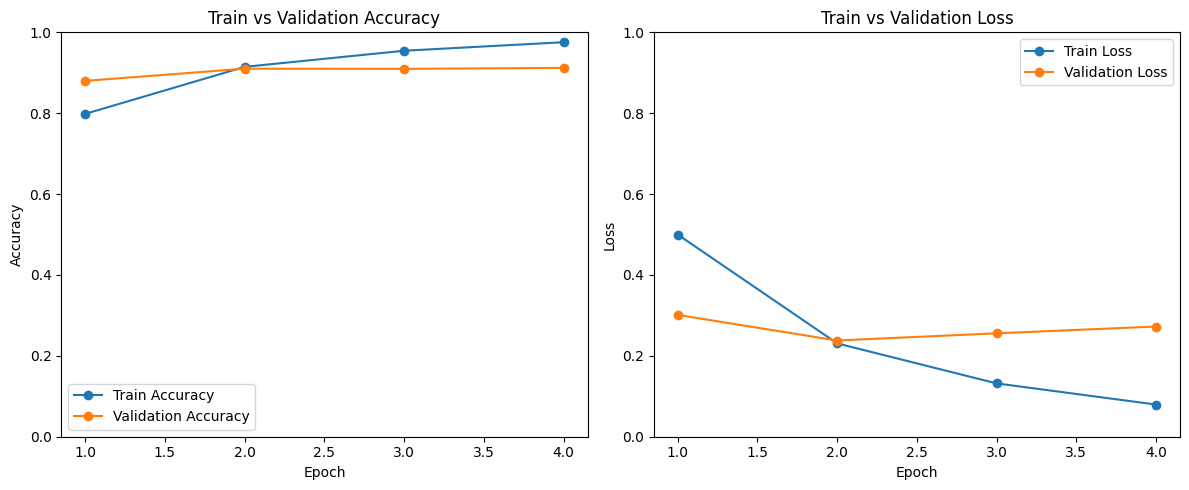

In [31]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.ylim(0, 1)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_loss'], label='Train Loss', marker='o')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.ylim(0, 1)
plt.legend()


plt.tight_layout()
plt.show()

### Final Evaluation on Test Set + Visualization

In [22]:
# Final evaluation on test set
test_loss, test_acc, test_prec, test_rec, test_f1, y_true, y_pred = eval_model(model, test_loader, loss_fn)
print(f"\nTest Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_rec:.4f}, F1: {test_f1:.4f}")

Evaluating: 100%|██████████| 107/107 [00:09<00:00, 11.52it/s]


Test Loss: 0.2684, Accuracy: 0.9120, Precision: 0.9134, Recall: 0.9120, F1: 0.9125


In [23]:
print("\nTest Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


Test Classification Report:
               precision    recall  f1-score   support

     negative       0.95      0.95      0.95      2038
     positive       0.89      0.87      0.88       939
very negative       0.73      0.84      0.78       160
very positive       0.82      0.85      0.84       273

     accuracy                           0.91      3410
    macro avg       0.85      0.87      0.86      3410
 weighted avg       0.91      0.91      0.91      3410



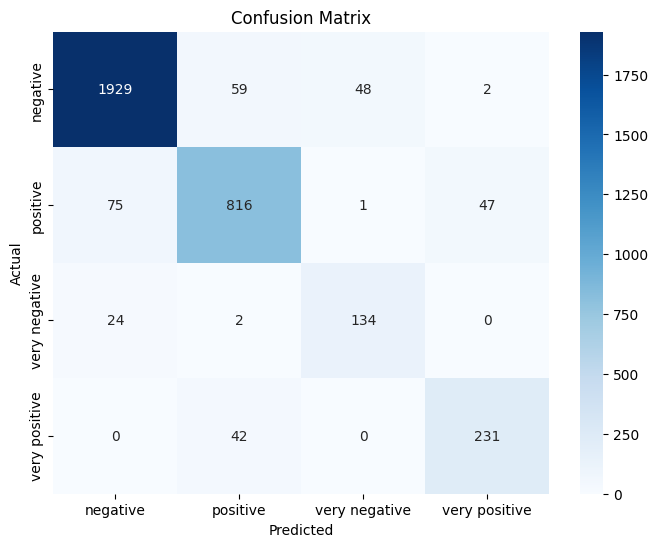

In [24]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

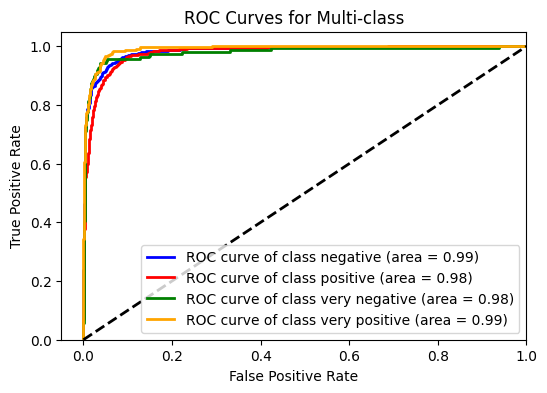

In [25]:
# Binarize labels for ROC-AUC calculation
y_true_bin = label_binarize(y_true, classes=[0,1,2,3])
num_classes = y_true_bin.shape[1]

# Get model logits for test set to compute ROC AUC
model.eval()
all_logits = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_logits.append(logits.detach().cpu().numpy())
all_logits = np.vstack(all_logits)

# Softmax probabilities
probs = torch.softmax(torch.tensor(all_logits), dim=1).numpy()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.figure(figsize=(6, 4))
colors = ['blue', 'red', 'green', 'orange']
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc[i] = roc_auc_score_func(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-class')
plt.legend(loc="lower right")
plt.show()

## **1️⃣ Save model and tokenizer locally in Kaggle’s output directory**

In [26]:
# Save directory (Kaggle output folder)
save_path = "/kaggle/working/bert_sentiment_model"

# Save model
model.save_pretrained(save_path)

# Save tokenizer as well (important for inference)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer.save_pretrained(save_path)

('/kaggle/working/bert_sentiment_model/tokenizer_config.json',
 '/kaggle/working/bert_sentiment_model/special_tokens_map.json',
 '/kaggle/working/bert_sentiment_model/vocab.txt',
 '/kaggle/working/bert_sentiment_model/added_tokens.json')

### <center>🙏 *Thank You!* </center>
<center> Thank you for exploring this notebook! 💙 </center>
<center> If you found it helpful, please consider giving it an upvote 👍</center>
<center>----</center>

Feel free to leave comments, suggestions, or questions. I’d love to hear your feedback! 😊

👉 Don’t forget to check out **[Notebook 1: Data Cleaning & NLP Pipeline](https://www.kaggle.com/code/dhaouadiibtihel98/clean-data-sentiment-analysis-lda-topic-modeling/notebook#%F0%9F%94%8D-Step-3:-Load-and-Explore-the-Dataset)** if you haven’t already!